In [ ]:
# Import libraries and set up paths
import json, os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

NOTEBOOK_DIR = Path.cwd()
OUTPUT_DIR = NOTEBOOK_DIR / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)
DATA_DIR = NOTEBOOK_DIR.parents[1] / "data" / "arc1"
TRAIN_DIR = DATA_DIR / "training"
EVAL_DIR = DATA_DIR / "evaluation"

ARC_COLORS = {
    0: "#000000",  # black
    1: "#0074D9",  # blue
    2: "#FF4136",  # red
    3: "#2ECC40",  # green
    4: "#FFDC00",  # yellow
    5: "#AAAAAA",  # gray
    6: "#F012BE",  # magenta
    7: "#FF851B",  # orange
    8: "#7FDBFF",  # light blue
    9: "#870C25",  # brown
}


def load_directory(path):
    tasks = {}
    for file in path.glob("*.json"):
        with open(file, "r") as f:
            tasks[file.stem] = json.load(f)
    return tasks


def save_plot(filename=None, directory=OUTPUT_DIR, dpi=300):
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"plot_{timestamp}.png"
    path = os.path.join(directory, filename)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to: {path}")


training_raw = load_directory(TRAIN_DIR)
evaluation_raw = load_directory(EVAL_DIR)

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\Grid_Height_vs_Width_(Training_Set)


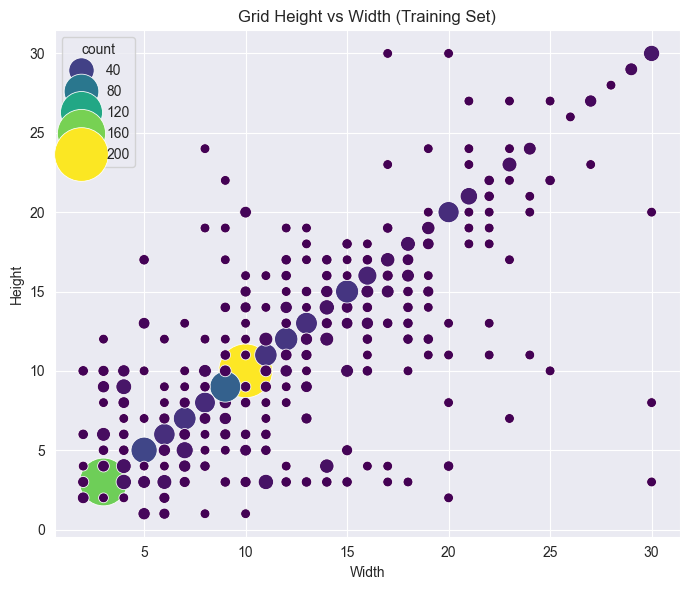

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\Grid_Height_vs_Width_(Evaluation_Set)


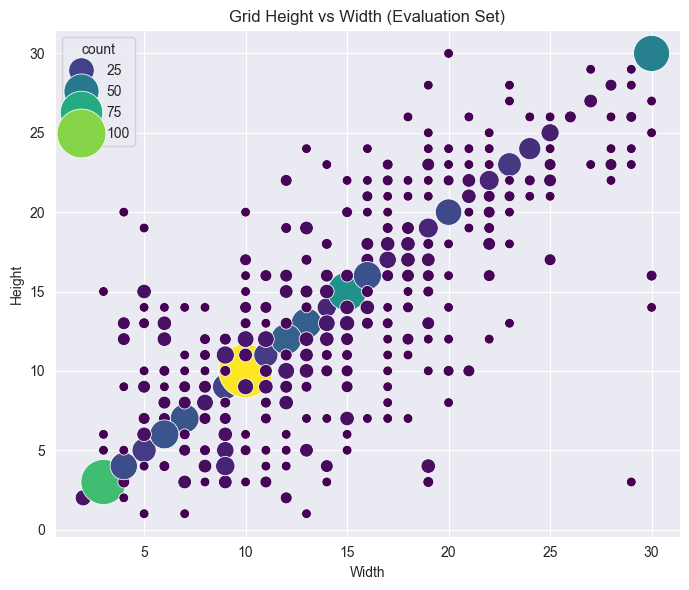

In [ ]:
# Extract and plot grid shape distributions
def extract_grid_shapes(tasks):
    shapes = []
    for task_id, task in tasks.items():
        for pair in task["train"]:
            grid = np.array(pair["input"])
            shapes.append((grid.shape[0], grid.shape[1]))
    return shapes

def plot_grid_shape_distribution(shapes, title):
    df = pd.DataFrame(shapes, columns=["height", "width"])
    counts = Counter((h, w) for h, w in zip(df["height"], df["width"]))
    plot_df = pd.DataFrame(
        [(h, w, c) for (h, w), c in counts.items()],
        columns=["height", "width", "count"]
    )
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        data=plot_df,
        x="width",
        y="height",
        size="count",
        sizes=(50, 1500),
        hue="count",
        palette="viridis",
        legend="brief"
    )
    plt.title(title)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.gca()
    plt.tight_layout()
    save_plot(title.replace(" ", "_"))
    plt.show()


train_shapes = extract_grid_shapes(training_raw)
eval_shapes = extract_grid_shapes(evaluation_raw)

plot_grid_shape_distribution(train_shapes, "Grid Height vs Width (Training Set)")
plot_grid_shape_distribution(eval_shapes, "Grid Height vs Width (Evaluation Set)")

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\color_freq_train.png


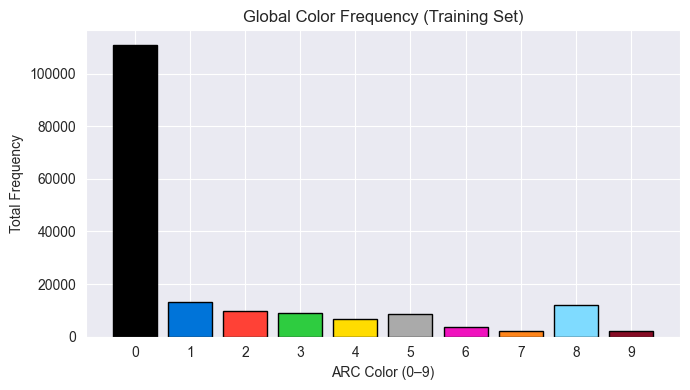

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\color_freq_eval.png


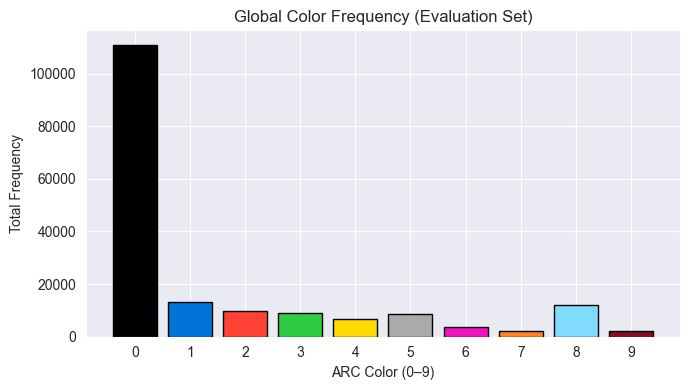

In [ ]:
# Extract and plot color frequency distributions
def extract_color_counts(tasks):
    counts = []
    for task_id, task in tasks.items():
        for pair in task["train"]:
            arr = np.array(pair["input"]).flatten()
            for color in range(10):
                counts.append({
                    "color": color,
                    "count": np.sum(arr == color)
                })
    return pd.DataFrame(counts)


def plot_arc_color_frequencies(df_color_sum, title, filename=None):
    plt.figure(figsize=(7, 4))
    plt.bar(
        df_color_sum["color"],
        df_color_sum["count"],
        color=[ARC_COLORS[c] for c in df_color_sum["color"]],
        edgecolor="black"
    )
    plt.xticks(df_color_sum["color"])
    plt.xlabel("ARC Color (0–9)")
    plt.ylabel("Total Frequency")
    plt.title(title)
    plt.tight_layout()
    save_plot(filename)
    plt.show()


train_colors = extract_color_counts(training_raw)
train_color_sum = train_colors.groupby("color")["count"].sum().reset_index()

eval_colors = extract_color_counts(evaluation_raw)
eval_color_sum = train_colors.groupby("color")["count"].sum().reset_index()

plot_arc_color_frequencies(
    train_color_sum,
    "Global Color Frequency (Training Set)",
    filename="color_freq_train.png"
)

plot_arc_color_frequencies(
    eval_color_sum,
    "Global Color Frequency (Evaluation Set)",
    filename="color_freq_eval.png"
)

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\symmetry_hist_train.png


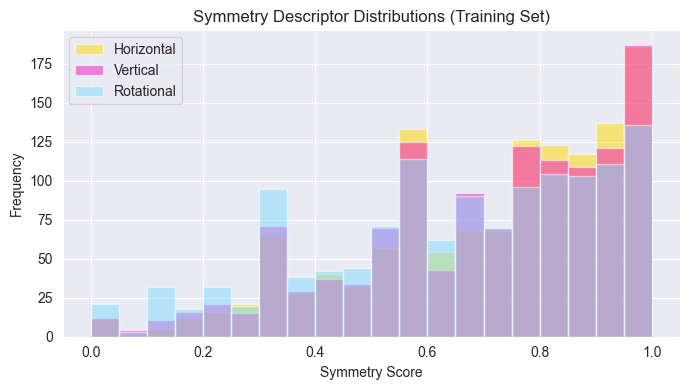

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\symmetry_corr_train.png


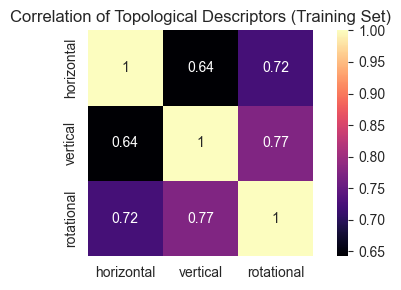

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\symmetry_hist_eval.png


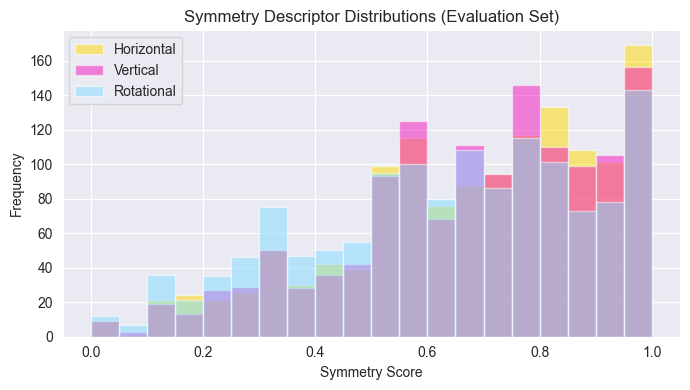

Saved figure to: C:\Users\kvand\PycharmProjects\ARC\arc1\visualization\outputs\symmetry_corr_eval.png


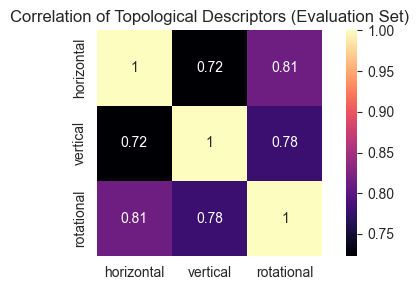

In [ ]:
# Extract and plot symmetry descriptors
def symmetry_score(a, b):
    return np.mean(a == b)

def horizontal_symmetry(grid):
    return symmetry_score(grid, np.fliplr(grid))

def vertical_symmetry(grid):
    return symmetry_score(grid, np.flipud(grid))

def rotational_symmetry(grid):
    return symmetry_score(grid, np.rot90(grid, 2))

def extract_topology(tasks):
    rows = []
    for task_id, task in tasks.items():
        for pair in task["train"]:
            grid = np.array(pair["input"])
            rows.append({
                "horizontal": horizontal_symmetry(grid),
                "vertical": vertical_symmetry(grid),
                "rotational": rotational_symmetry(grid)
            })
    return pd.DataFrame(rows)


def plot_symmetry_histograms(df_topo, title, filename=None):
    plt.figure(figsize=(7, 4))
    plt.hist(
        df_topo["horizontal"],
        bins=20,
        alpha=0.5,
        color=ARC_COLORS[4],
        label="Horizontal"
    )
    plt.hist(
        df_topo["vertical"],
        bins=20,
        alpha=0.5,
        color=ARC_COLORS[6],
        label="Vertical"
    )
    plt.hist(
        df_topo["rotational"],
        bins=20,
        alpha=0.5,
        color=ARC_COLORS[8],
        label="Rotational"
    )
    plt.xlabel("Symmetry Score")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    save_plot(filename)
    plt.show()


def plot_topology_correlation(df_topo, title, filename=None):
    plt.figure(figsize=(5, 3))
    sns.heatmap(
        df_topo.corr(),
        annot=True,
        cmap="magma",
        square=True
    )
    plt.title(title)
    plt.tight_layout()
    save_plot(filename)
    plt.show()


train_topo = extract_topology(training_raw)
eval_topo = extract_topology(evaluation_raw)

plot_symmetry_histograms(
    train_topo,
    "Symmetry Descriptor Distributions (Training Set)",
    filename="symmetry_hist_train.png"
)

plot_topology_correlation(
    train_topo,
    "Correlation of Topological Descriptors (Training Set)",
    filename="symmetry_corr_train.png"
)

plot_symmetry_histograms(
    eval_topo,
    "Symmetry Descriptor Distributions (Evaluation Set)",
    filename="symmetry_hist_eval.png"
)

plot_topology_correlation(
    eval_topo,
    "Correlation of Topological Descriptors (Evaluation Set)",
    filename="symmetry_corr_eval.png"
)